# Feature Selection

## Overview
This notebook selects the most informative features for the classification task, using only the training data to avoid data leakage. The number of features and the selection method are defined in `config.toml`.

**Key steps:**
- Load processed data from preprocessing
- Fit feature selection on training data only
- Apply selected features to both train and test sets
- Visualize feature importances and selection results
- Save reduced datasets and selection info for modeling

**Why feature selection?**
- Reduces overfitting
- Improves model interpretability
- Speeds up training and inference
- Can improve model performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import toml
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# Load config
config = toml.load('../config.toml')
fs_config = config['feature_selection']
n_features = fs_config.get('n_features', 50)
method = fs_config.get('method', 'model_importance')
scoring = fs_config.get('scoring', 'f_classif')

print(f"Feature selection method: {method}")
print(f"Number of features to select: {n_features}")
print(f"Scoring/model: {scoring}")

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])

Feature selection method: select_k_best
Number of features to select: 10
Scoring/model: f_classif


In [2]:
# Load processed data from previous step
data_dir = Path('../data/processed')
with open(data_dir / '03_processed_data.pkl', 'rb') as f:
    processed_data = pickle.load(f)

X_train = pd.DataFrame(processed_data['X_train'], columns=processed_data['feature_cols'])
X_test = pd.DataFrame(processed_data['X_test'], columns=processed_data['feature_cols'])
y_train = processed_data['y_train']
y_test = processed_data['y_test']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (24, 30)
Test set shape: (6, 30)


## Feature Selection Strategy

We will fit the feature selection method **only on the training data** to avoid data leakage. The selected features will then be used to filter both the training and test sets.

**Supported methods:**
- `select_k_best`: Univariate feature selection (requires `scoring`)
    - `f_classif`: ANOVA F-value
    - `mutual_info`: Mutual information
- `model_importance`: Model-based (e.g., Random Forest)
- `variance`: Variance threshold (not supervised)
- `rfe`, `lasso`, etc. (future extensions)

In [3]:
method = fs_config.get('method', 'select_k_best')
scoring = fs_config.get('scoring', 'f_classif')
n_features = fs_config.get('n_features', 100)

if method == 'select_k_best':
    if scoring == 'f_classif':
        selector = SelectKBest(score_func=f_classif, k=n_features)
    elif scoring == 'mutual_info':
        selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
    else:
        raise ValueError(f"Unknown scoring function for select_k_best: {scoring}")
    selector.fit(X_train, y_train)
    scores = selector.scores_
    feature_scores = pd.Series(scores, index=X_train.columns)
    selected_mask = selector.get_support()
    selected_features = X_train.columns[selected_mask]
    importance_type = scoring
elif method == 'model_importance':
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    feature_scores = pd.Series(importances, index=X_train.columns)
    selected_features = feature_scores.sort_values(ascending=False).head(n_features).index
    selected_mask = X_train.columns.isin(selected_features)
    importance_type = "Random Forest Importance"
elif method == 'variance':
    from sklearn.feature_selection import VarianceThreshold
    selector = VarianceThreshold()
    selector.fit(X_train)
    variances = selector.variances_
    feature_scores = pd.Series(variances, index=X_train.columns)
    selected_features = feature_scores.sort_values(ascending=False).head(n_features).index
    selected_mask = X_train.columns.isin(selected_features)
    importance_type = "Variance"
else:
    raise ValueError(f"Unknown feature selection method: {method}")

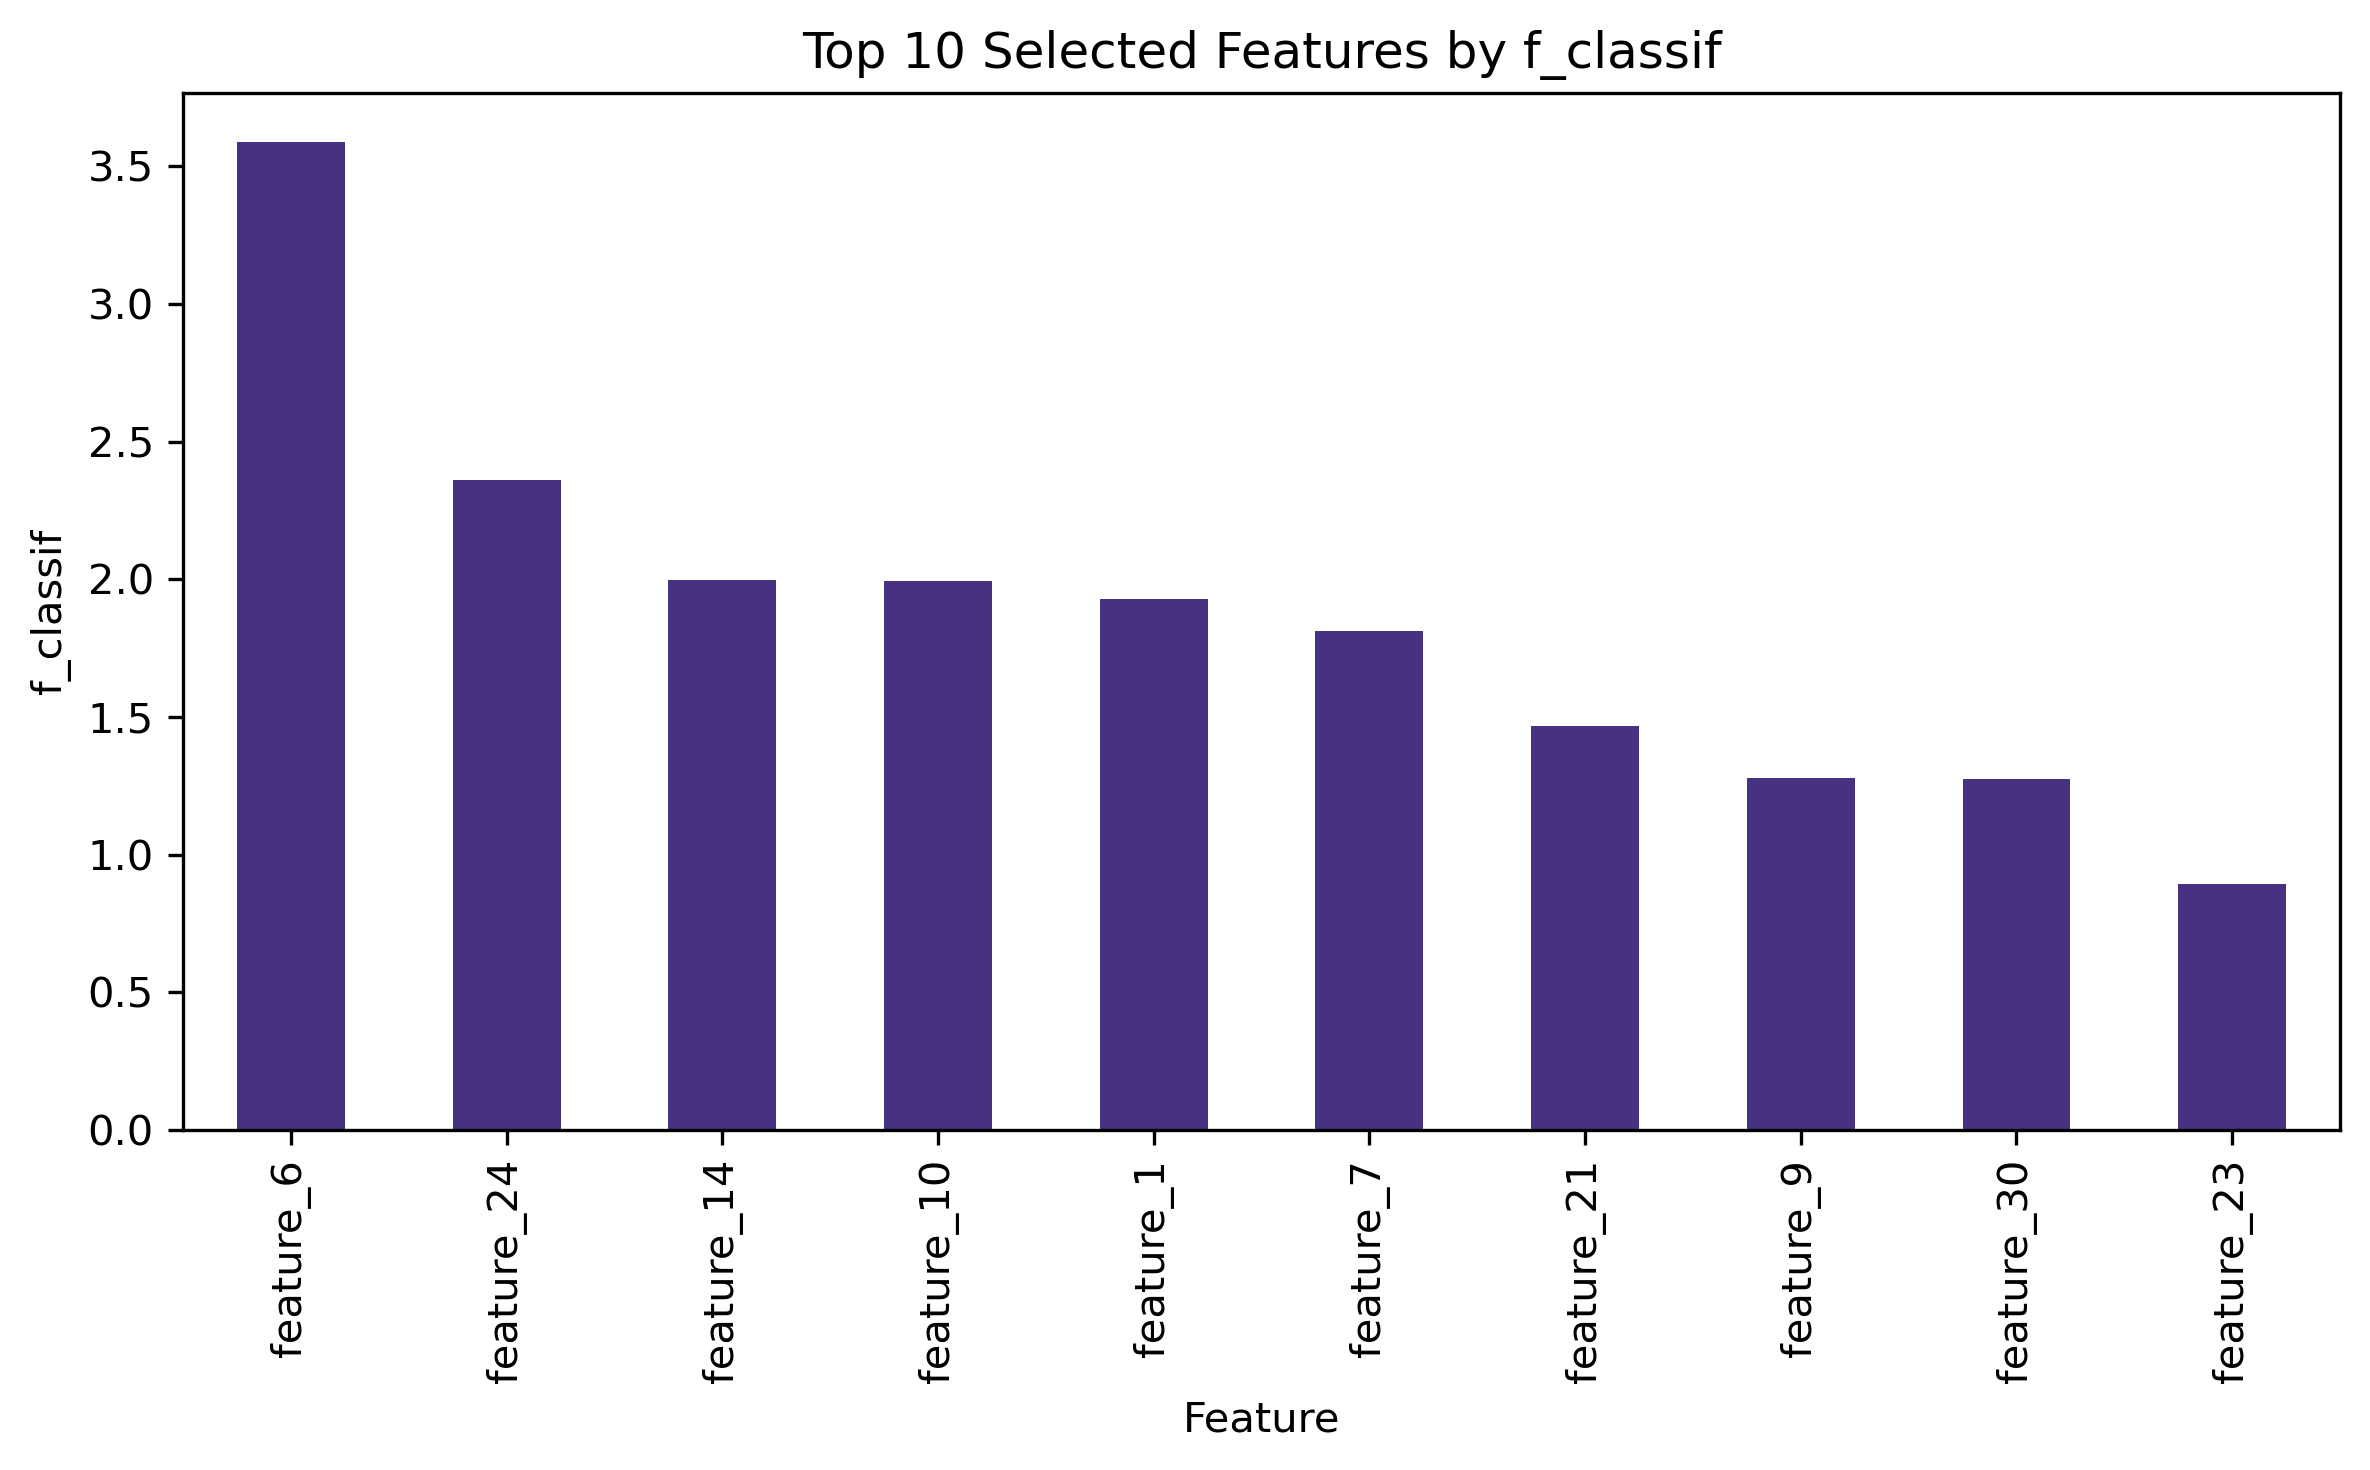

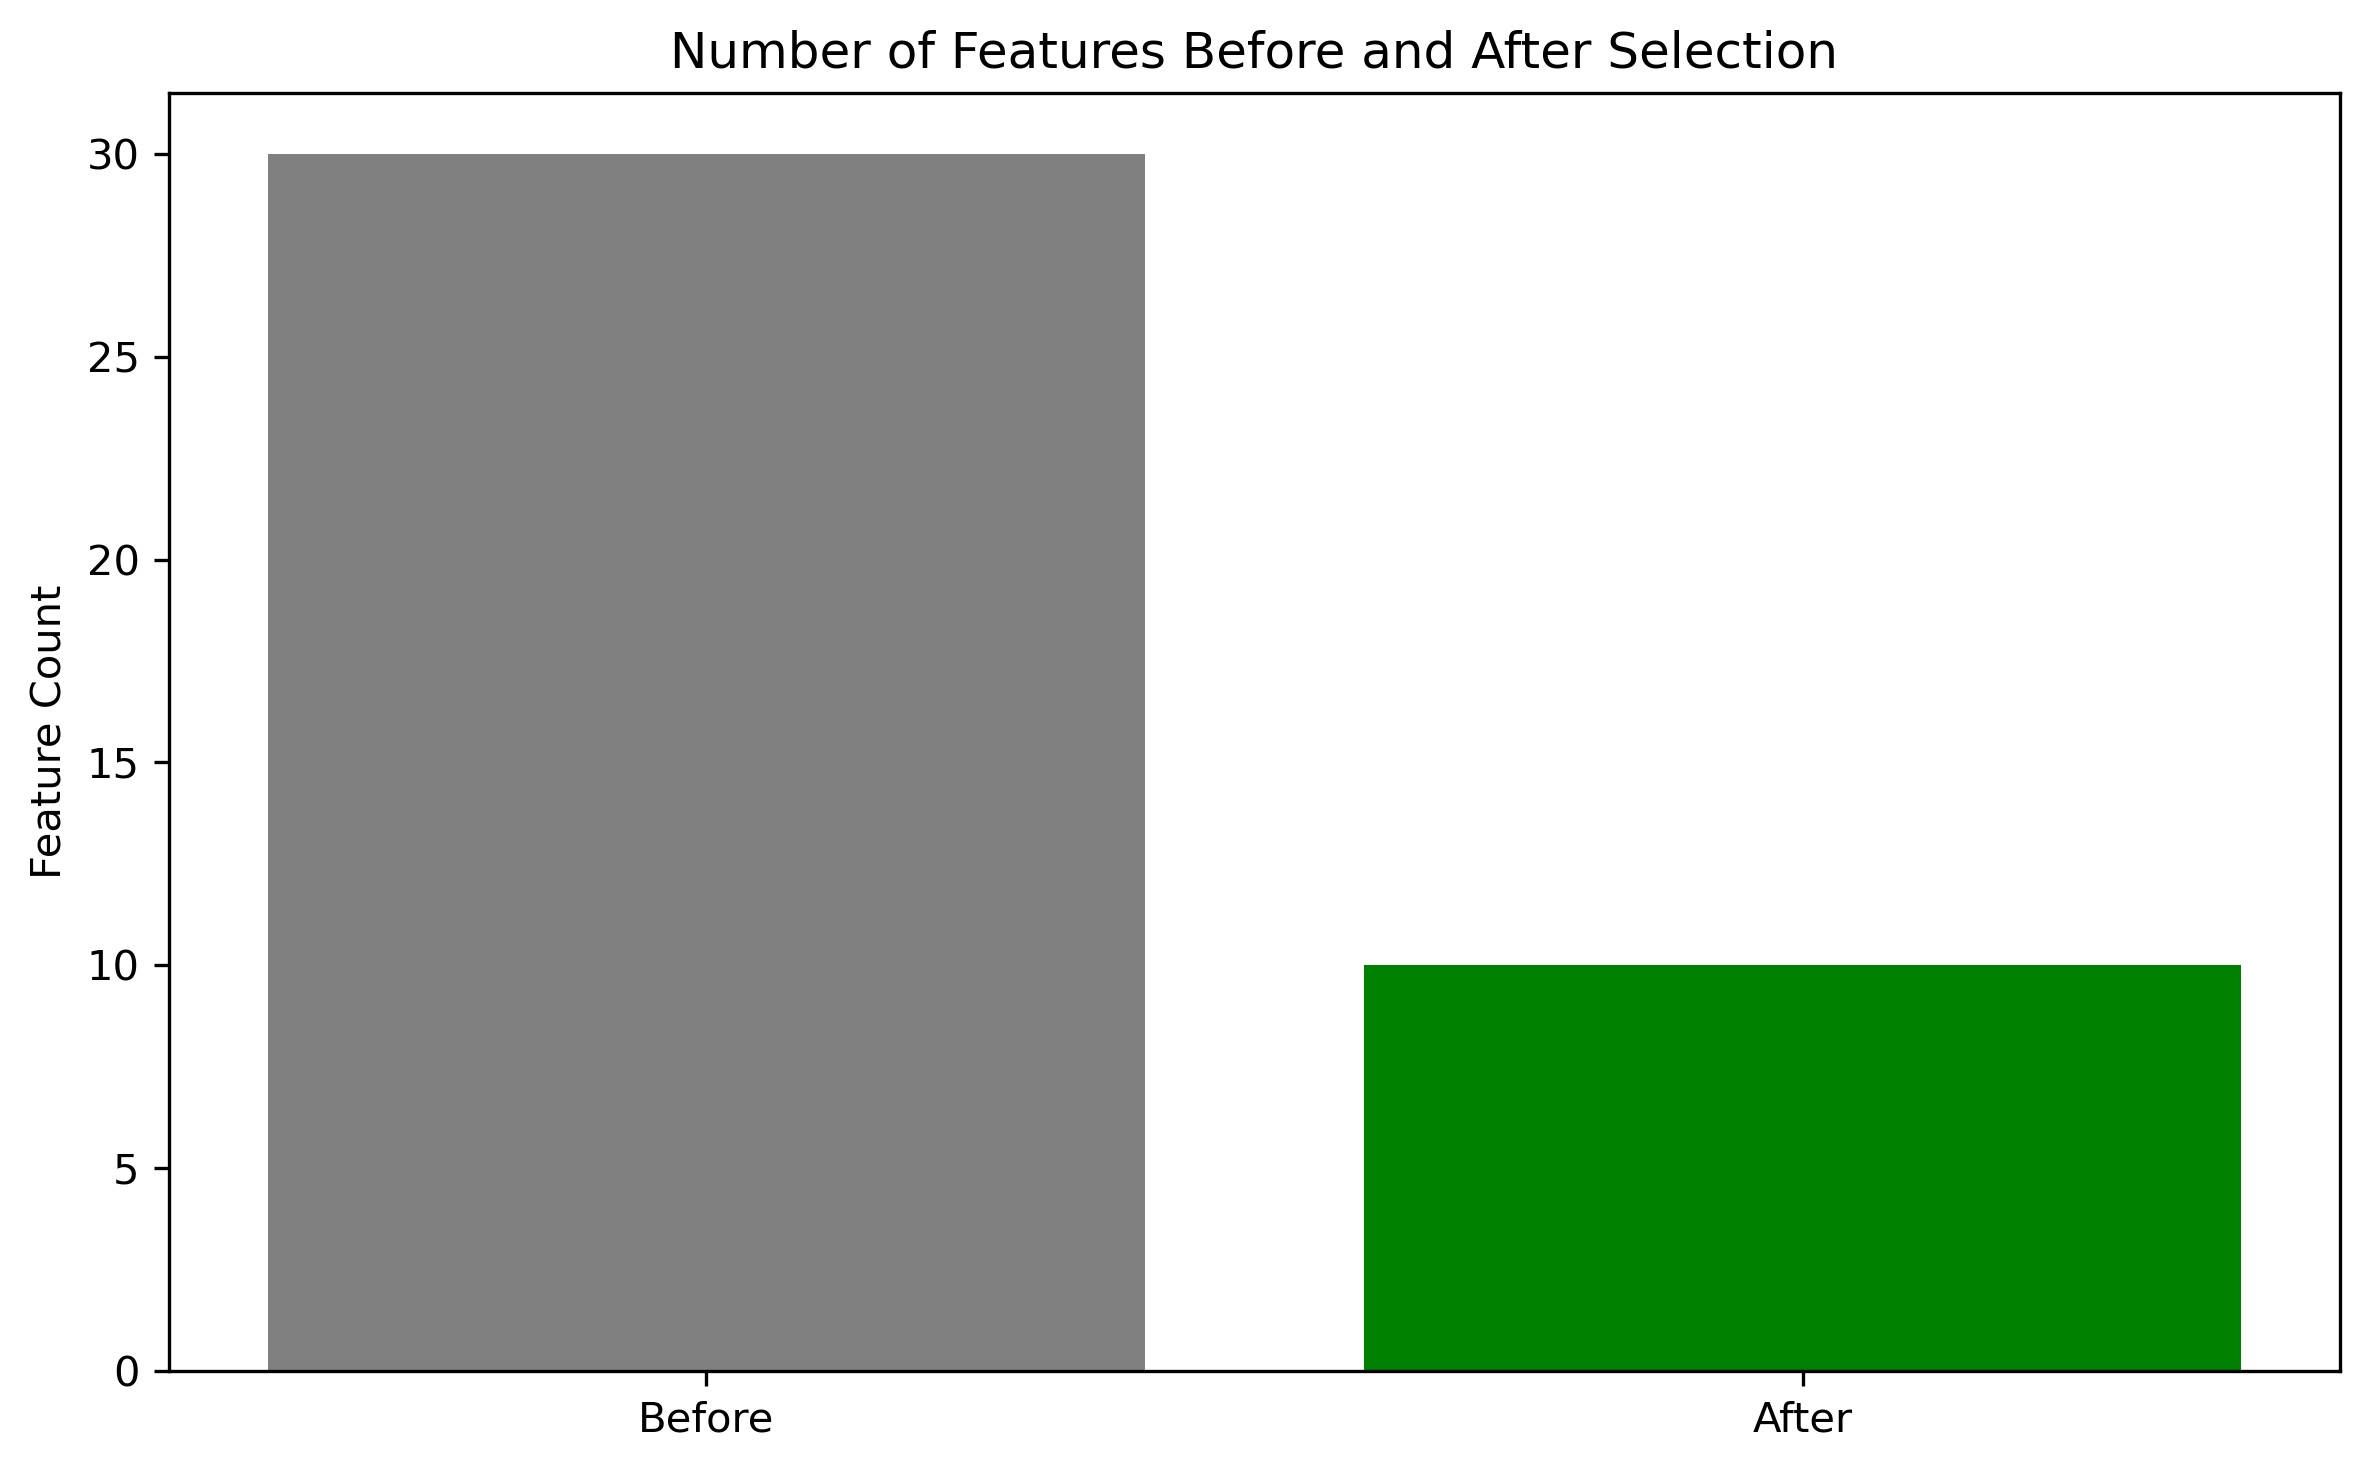

In [4]:
# Visualize feature importances
plt.figure()
top_n = min(30, len(selected_features))
feature_scores[selected_features].sort_values(ascending=False)[:top_n].plot(kind='bar')
plt.title(f"Top {top_n} Selected Features by {importance_type}")
plt.ylabel(importance_type)
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Visualize before/after feature count
plt.figure()
plt.bar(['Before', 'After'], [X_train.shape[1], len(selected_features)], color=['gray', 'green'])
plt.title("Number of Features Before and After Selection")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()

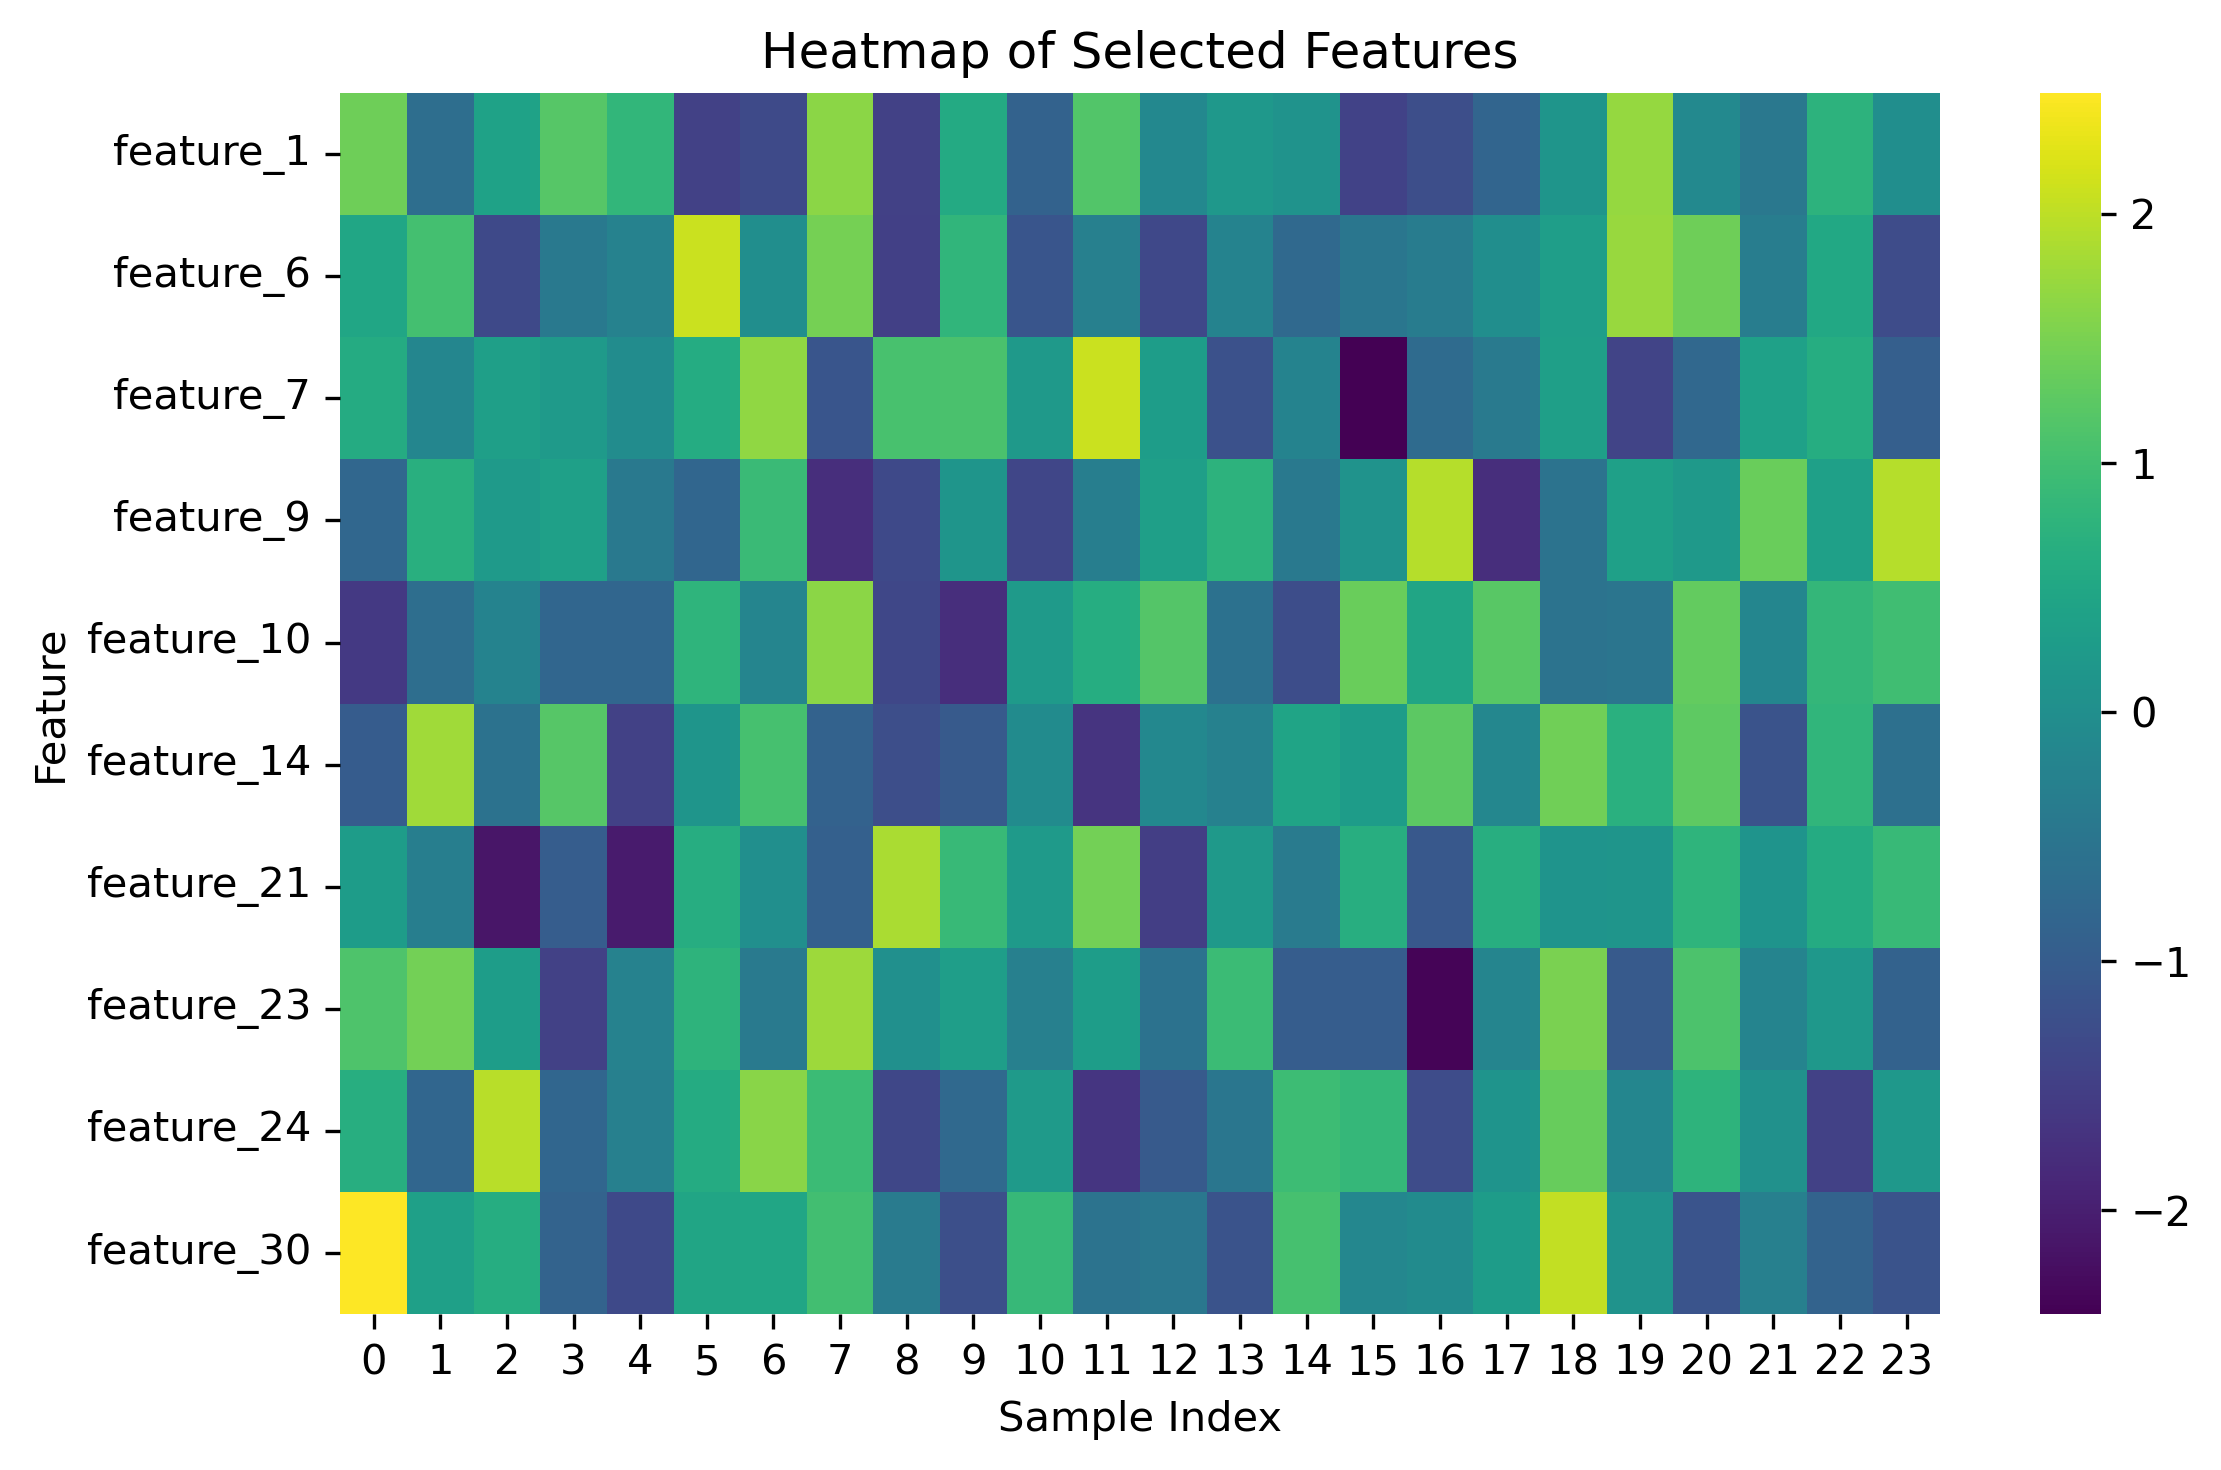

In [5]:
# Heatmap of selected features (first 100 samples)
plt.figure()
sns.heatmap(X_train[selected_features].T, cmap='viridis', cbar=True)
plt.title("Heatmap of Selected Features")
plt.xlabel("Sample Index")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [6]:
# Subset both train and test sets to selected features
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

print(f"Reduced training set shape: {X_train_selected.shape}")
print(f"Reduced test set shape: {X_test_selected.shape}")

Reduced training set shape: (24, 10)
Reduced test set shape: (6, 10)


In [7]:
# Save reduced datasets and feature selection info
output = {
    'X_train_selected': X_train_selected,
    'X_test_selected': X_test_selected,
    'y_train': y_train,
    'y_test': y_test,
    'selected_features': list(selected_features),
    'feature_scores': feature_scores.to_dict(),
    'method': method,
    'importance_type': importance_type
}

with open(data_dir / '04_feature_selection.pkl', 'wb') as f:
    pickle.dump(output, f)

print("Feature selection results saved to 04_feature_selection.pkl")

Feature selection results saved to 04_feature_selection.pkl


## Summary

- Selected the top features using **only the training data** and the method specified in `config.toml`
- Visualized feature importances and the effect of selection
- Saved the reduced datasets and selection info for modeling

**Next:**  
Proceed to model training using only the selected features for both training and test sets.